# Empirical exercise

In [2]:
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import japanize_matplotlib

import statsmodels.api as sm
import statsmodels.formula.api as smf

from tqdm import tqdm
import pickle

import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('ggplot')

In [4]:
class Config:
    DATA_DIR = Path('data/')

cfg = Config

## Preprocess

In [5]:
with open(cfg.DATA_DIR / 'GDP.txt') as f:
    lines_list = f.readlines()

In [6]:
gdp_dict = {
    'GDP60' : [],
    'GDP85' : [],
}
for line in lines_list:
    gdp60 = line.replace('\n', '').split('\t')[0]
    gdp85 = line.replace('\n', '').split('\t')[1]
    gdp_dict['GDP60'].append(int(gdp60))
    gdp_dict['GDP85'].append(int(gdp85))

gdp_df = pd.DataFrame(gdp_dict)

In [7]:
gdp_df['y'] = (1/25)*np.log(gdp_df['GDP85']/gdp_df['GDP60'])
gdp_df

,GDP60,GDP85,y
0,1302,2142,0.019914
1,880,609,-0.014724
2,595,525,-0.005007
3,493,1762,0.050948
4,412,345,-0.007099
...,...,...,...
109,4970,8665,0.022235
110,5182,8850,0.021409
111,1799,2893,0.019003
112,5571,8000,0.014475


In [8]:
# gdp_df.to_csv(cfg.DATA_DIR / 'GDP.csv', index=False)

## Ex.1-1

In [9]:
y = gdp_df['y']
X = gdp_df['GDP60']
X = sm.add_constant(X)
model_ols = sm.OLS(y, X)
ols_res = model_ols.fit()
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.064
Date:                Tue, 25 Jun 2024   Prob (F-statistic):              0.154
Time:                        13:57:12   Log-Likelihood:                 288.15
No. Observations:                 114   AIC:                            -572.3
Df Residuals:                     112   BIC:                            -566.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0175      0.003      6.706      0.000       0.012       0.023
GDP60       1.507e-06   1.05e-06      1.437      0.154   -5.71e-07    3.58e-06
==============================================================================
Omnibus:                        1.099   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.577   Jarque-Bera (JB):                0.890
Skew:                           0.216   Prob(JB):                        0.641
Kurtosis:                       3.021   Cond. No.                     3.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Ex. 1-2

In [10]:
y = gdp_df['y']
X = gdp_df['GDP60']
X = sm.add_constant(X)
model = sm.OLS(y, X)
ols_res = model.fit()
residual = ols_res.resid
residual_squared = residual**2 

In [11]:
gdp_df['x2'] = gdp_df['GDP60']**2

X_skd = gdp_df[['GDP60', 'x2']]
X_skd = sm.add_constant(X_skd)

model_skd = sm.OLS(residual_squared, X_skd)
skd_res= model_skd.fit()
skd_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.268
Date:                Tue, 25 Jun 2024   Prob (F-statistic):              0.108
Time:                        13:57:12   Log-Likelihood:                 700.24
No. Observations:                 114   AIC:                            -1394.
Df Residuals:                     111   BIC:                            -1386.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      4.288      0.000       0.000       0.001
GDP60      -1.812e-08   1.07e-07     -0.169      0.866    -2.3e-07    1.94e-07
x2         -6.865e-12   1.72e-11     -0.399      0.691    -4.1e-11    2.72e-11
==============================================================================
Omnibus:                       72.154   Durbin-Watson:                   2.345
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.554
Skew:                           2.323   Prob(JB):                     3.62e-63
Kurtosis:                       9.241   Cond. No.                     2.64e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
sigma_squared = skd_res.fittedvalues
w = 1.0 / np.sqrt(sigma_squared)

X_w = X.apply(lambda row: row * w, axis=0)
y_w = y*w

In [13]:
print(w[w.isna()])
print(1/np.sqrt(sigma_squared.iloc[55]))
sigma_squared.iloc[55]

55   NaN
dtype: float64
nan


-5.9737659905225436e-05

In [14]:
# 分散が計算できなかった55行目のサンプルを削除する
X_w = X_w.dropna(how='all')
y_w = y_w.drop(index=55)

model_gls = sm.OLS(y_w, X_w)
gls_res = model_gls.fit()
gls_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.674
Model:                            OLS   Adj. R-squared (uncentered):              0.668
Method:                 Least Squares   F-statistic:                              114.5
Date:                Tue, 25 Jun 2024   Prob (F-statistic):                    1.04e-27
Time:                        13:57:13   Log-Likelihood:                         -160.62
No. Observations:                 113   AIC:                                      325.2
Df Residuals:                     111   BIC:                                      330.7
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0199      0.003      7.957      0.000       0.015       0.025
GDP60      -1.295e-07   4.81e-07     -0.269      0.788   -1.08e-06    8.24e-07
==============================================================================
Omnibus:                        0.078   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.962   Jarque-Bera (JB):                0.037
Skew:                          -0.040   Prob(JB):                        0.982
Kurtosis:                       2.961   Cond. No.                     1.02e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
gls_res.params

const    1.993934e-02
GDP60   -1.295052e-07
dtype: float64

## Ex.1-3

In [16]:
model_quantile_dict = {}
result_quantile_dict = {}
quantiles = range(1, 10)
for q in quantiles:
    model = smf.quantreg('y ~ GDP60', gdp_df)
    res = model.fit(q=q*0.1)
    model_quantile_dict[q*0.1] = model
    result_quantile_dict[q*0.1] = res
    print(f'{round(q*0.1, 1)}-Quantile Regression')
    print(res.params)

0.1-Quantile Regression
Intercept   -0.011296
GDP60        0.000004
dtype: float64
0.2-Quantile Regression
Intercept    0.000012
GDP60        0.000003
dtype: float64
0.3-Quantile Regression
Intercept    0.002912
GDP60        0.000003
dtype: float64
0.4-Quantile Regression
Intercept    0.009885
GDP60        0.000002
dtype: float64
0.5-Quantile Regression
Intercept    0.016104
GDP60        0.000002
dtype: float64
0.6-Quantile Regression
Intercept    2.375734e-02
GDP60        6.590276e-07
dtype: float64
0.7-Quantile Regression
Intercept    3.104945e-02
GDP60       -4.467929e-07
dtype: float64
0.8-Quantile Regression
Intercept    0.036381
GDP60       -0.000001
dtype: float64
0.9-Quantile Regression
Intercept    0.051791
GDP60       -0.000004
dtype: float64


## Ex.1-4

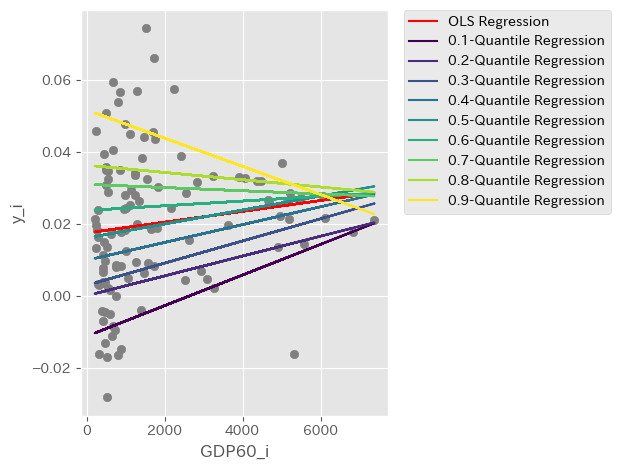

In [17]:
plt.scatter(gdp_df['GDP60'], gdp_df['y'], color='grey')
plt.plot(gdp_df['GDP60'], ols_res.fittedvalues, color='red', label='OLS Regression')
quantiles = range(1, 10)
colors = plt.cm.viridis(np.linspace(0, 1, len(quantiles)))
for q, color in zip(quantiles, colors):
    plt.plot(gdp_df['GDP60'], result_quantile_dict[q*0.1].fittedvalues, color=color, label=f'{round(q*0.1, 1)}-Quantile Regression')
plt.xlabel('GDP60_i')
plt.ylabel('y_i')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()